In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
from lazypredict import Supervised
import sklearn

Učitavanje podataka - Nivo vlažnosti, Temperatura, Period u danu, Da li je bogomoljka uspešno namamila svoj plen, Vreme utrošeno na lov, Veličina plena, Da li je bogomoljka lovila iz zasede, Da li su bili prisutni drugi predatori, Da li se bogomoljka takmičila za plen, Da li je bogomoljka bila uspešna u lovu
Odluka: Radiće se klasifikacija za Hunting Success, model na osnovu zadatih parametara treba da predvidi da li je lov bio uspešan ili ne

In [2]:
dataset = pd.read_csv('../data/data.csv')

dataset.head(5)

,Humidity Level,Temperature,Time of Day,Luring Success,Time Spent Hunting,Prey Size,Ambush,Food Availability,Predator Presence,Is Competition,Hunting Success
0,0.32,31.25,Morning,True,0.81,6.60,False,NaN,True,False,0
1,0.66,29.08,Afternoon,False,2.81,5.38,False,Low,False,False,1
2,0.61,25.74,Evening,True,3.79,15.19,True,Low,False,False,1
3,0.37,22.68,Morning,False,4.27,5.06,True,Low,True,False,1
4,0.65,29.20,Afternoon,False,3.84,2.71,False,High,False,False,1


Prikaz osnovnih informacija

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Humidity Level      300000 non-null  float64
 1   Temperature         300000 non-null  float64
 2   Time of Day         300000 non-null  object 
 3   Luring Success      300000 non-null  bool   
 4   Time Spent Hunting  300000 non-null  float64
 5   Prey Size           300000 non-null  float64
 6   Ambush              300000 non-null  bool   
 7   Food Availability   269788 non-null  object 
 8   Predator Presence   270292 non-null  object 
 9   Is Competition      269881 non-null  object 
 10  Hunting Success     300000 non-null  int64  
dtypes: bool(2), float64(4), int64(1), object(4)
memory usage: 21.2+ MB


Prikaz sumirane statistike

In [4]:
dataset.describe()

,Humidity Level,Temperature,Time Spent Hunting,Prey Size,Hunting Success
count,300000.00,300000.00,300000.00,300000.00,300000.00
mean,0.60,27.50,2.73,5.66,0.55
std,0.17,4.33,1.41,2.82,0.50
min,0.30,20.00,0.40,1.00,0.00
25%,0.45,23.75,1.55,3.31,0.00
50%,0.60,27.49,2.69,5.59,1.00
75%,0.75,31.25,3.84,7.88,1.00
max,0.90,35.00,10.19,20.97,1.00


### Analiza raspodele target varijable

In [5]:
hunting_success_dist = dataset['Hunting Success'].value_counts()
print("Raspodela Hunting Success:")
print(hunting_success_dist)
print(f"\nProcenat: {hunting_success_dist / len(dataset) * 100}")

Raspodela Hunting Success:
Hunting Success
1    164957
0    135043
Name: count, dtype: int64

Procenat: Hunting Success
1   54.99
0   45.01
Name: count, dtype: float64


Zapažanje: Dataset je balansiran - obe klase su približno jednako zastupljene.

Provera koliko duplikata postoji u setu podataka

In [6]:
broj_duplikata = dataset.duplicated().sum()
print(f'Broj duplikata: {broj_duplikata}')

Broj duplikata: 0


Zapažanja: kolone 7, 8 i 9 su tipa object, iako u .csv-u imaju vrednosti TRUE i FALSE. 
Pretpostavka: Fale podaci u nekim redovima za ove vrednosti.
Prikazan broj praznih vrednosti po kolonama:

In [7]:
dataset.isnull().sum()

Humidity Level            0
Temperature               0
Time of Day               0
Luring Success            0
Time Spent Hunting        0
Prey Size                 0
Ambush                    0
Food Availability     30212
Predator Presence     29708
Is Competition        30119
Hunting Success           0
dtype: int64

Raspodela broja redova prema broju nedostajućih vrednosti:

In [8]:
dataset.isnull().sum(axis=1).value_counts()

0    218592
1     73107
2      7971
3       330
Name: count, dtype: int64

Procenat broja redova prema broju nedostajućih vrednosti - tabela

In [9]:
raspodela = dataset.isnull().sum(axis=1).value_counts().sort_index()
ukupan_broj_redova = len(dataset)

tabela = pd.DataFrame({
    'Broj nedostajućih vrednosti': raspodela.index,
    'Broj redova': raspodela.values,
    'Procenat (%)': (raspodela.values / ukupan_broj_redova * 100).round(2)
})

tabela


,Broj nedostajućih vrednosti,Broj redova,Procenat (%)
0,0,218592,72.86
1,1,73107,24.37
2,2,7971,2.66
3,3,330,0.11


Zapažanje: Većina redova sa praznim vrednostima ima samo jednu nedefinisanu vrednost.
Može se uraditi: Procenat redova kojima fali više od jedne vrednosti je jako mali(ispod 5%) i njihovo brisanje neće značajno uticati na ishod.
Procenat redova kojima nedostaje jedna vrednost predstavlja veliki deo dataseta i treba ih sačuvati za analizu. Prazne vrednosti se mogu zameniti validnim vrednostima na sledeće načine: 
1. Dopisivanjem FALSE u svako prazno polje - Može iskriviti odnos TRUE/FALSE
2. Probabilistička imputacija - Pronalaženje odnosa vrednosti TRUE/FALSE i popunjavanje dataset-a tako da se održi ova razmera - Očuvava se odnos TRUE/FALSE
3. Model based imputacija - Treniranje modela za popunjavanje vrednosti koje fale

Odabrana je opcija 2.

Brisanje redova sa više nedefinisanih vrednosti:

In [10]:
dataset = dataset[dataset.isnull().sum(axis=1) <= 1]
dataset.info()
dataset.head(5)

<class 'pandas.core.frame.DataFrame'>
Index: 291699 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Humidity Level      291699 non-null  float64
 1   Temperature         291699 non-null  float64
 2   Time of Day         291699 non-null  object 
 3   Luring Success      291699 non-null  bool   
 4   Time Spent Hunting  291699 non-null  float64
 5   Prey Size           291699 non-null  float64
 6   Ambush              291699 non-null  bool   
 7   Food Availability   267110 non-null  object 
 8   Predator Presence   267668 non-null  object 
 9   Is Competition      267212 non-null  object 
 10  Hunting Success     291699 non-null  int64  
dtypes: bool(2), float64(4), int64(1), object(4)
memory usage: 22.8+ MB


,Humidity Level,Temperature,Time of Day,Luring Success,Time Spent Hunting,Prey Size,Ambush,Food Availability,Predator Presence,Is Competition,Hunting Success
0,0.32,31.25,Morning,True,0.81,6.60,False,NaN,True,False,0
1,0.66,29.08,Afternoon,False,2.81,5.38,False,Low,False,False,1
2,0.61,25.74,Evening,True,3.79,15.19,True,Low,False,False,1
3,0.37,22.68,Morning,False,4.27,5.06,True,Low,True,False,1
4,0.65,29.20,Afternoon,False,3.84,2.71,False,High,False,False,1


Procentualni odnos vrednosti u kolonama sa True/False podacima

In [11]:
boolean_kolone = []
for kolona in dataset.columns:
    jedinstvene_vrednosti = dataset[kolona].dropna().unique()
    if set(jedinstvene_vrednosti).issubset({0, 1}):
        boolean_kolone.append(kolona)

rezultati = []
for kolona in boolean_kolone:
    ukupno = dataset[kolona].notna().sum()  
    broj_1 = (dataset[kolona] == 1).sum()
    broj_0 = (dataset[kolona] == 0).sum()
    
    proc_1 = (broj_1 / ukupno * 100).round(2) if ukupno > 0 else 0
    proc_0 = (broj_0 / ukupno * 100).round(2) if ukupno > 0 else 0
    
    rezultati.append({
        'Kolona': kolona,
        'Broj vrednosti TRUE/1': broj_1,
        'Broj vrednosti FALSE/0': broj_0,
        'Procenat TRUE/1 (%)': proc_1,
        'Procenat FALSE/0 (%)': proc_0,
        'Ukupno': ukupno
    })

tabela_boolean = pd.DataFrame(rezultati)
tabela_boolean


,Kolona,Broj vrednosti TRUE/1,Broj vrednosti FALSE/0,Procenat TRUE/1 (%),Procenat FALSE/0 (%),Ukupno
0,Luring Success,145980,145719,50.04,49.96,291699
1,Ambush,145594,146105,49.91,50.09,291699
2,Predator Presence,133661,134007,49.94,50.06,267668
3,Is Competition,133349,133863,49.90,50.10,267212
4,Hunting Success,160315,131384,54.96,45.04,291699


Prevođenje vrednosti kolona sa True/False u 1/0; 
Boolean atributi su transformisani u numerički oblik (0/1) kako bi se omogućila primena algoritama mašinskog učenja koji zahtevaju numeričke ulaze.

In [12]:
kolone = ['Predator Presence', 'Is Competition']

for kolona in kolone:
    dataset[kolona] = dataset[kolona].replace(r'(?i)^true$', 1, regex=True).replace(r'(?i)^false$', 0, regex=True)

for kolona in kolone:
    dataset[kolona] = pd.to_numeric(dataset[kolona], errors='coerce').astype('Int64')

Probabilistička imputacija za kolone sa nedostajućim vrednostima

In [13]:
kolone_boolean = ['Predator Presence', 'Is Competition']

for kol in kolone_boolean:
    p_true = dataset[kol].mean()
    
    dataset[kol] = dataset[kol].apply(
        lambda x: 1 if pd.notna(x) and x == 1 
        else (1 if pd.isna(x) and np.random.rand() < p_true else 0)
    )

if dataset['Food Availability'].isna().any():
    distribucija = dataset['Food Availability'].value_counts(normalize=True)
    kategorije = distribucija.index.tolist()
    verovatnoce = distribucija.values.tolist()
    
    nan_indeksi = dataset['Food Availability'].isna()
    
    dataset.loc[nan_indeksi, 'Food Availability'] = np.random.choice(
        kategorije, 
        size=nan_indeksi.sum(),
        p=verovatnoce,
    )

Transformacija bool TRUE/FALSE vrednosti u numeričke 0/1 int64

In [14]:
dataset = dataset.replace({True: 1, False: 0})

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 291699 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Humidity Level      291699 non-null  float64
 1   Temperature         291699 non-null  float64
 2   Time of Day         291699 non-null  object 
 3   Luring Success      291699 non-null  int64  
 4   Time Spent Hunting  291699 non-null  float64
 5   Prey Size           291699 non-null  float64
 6   Ambush              291699 non-null  int64  
 7   Food Availability   291699 non-null  object 
 8   Predator Presence   291699 non-null  int64  
 9   Is Competition      291699 non-null  int64  
 10  Hunting Success     291699 non-null  int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 26.7+ MB


<b style="background-color: #470047">Zaokruživanje na dve decimale</b> 

In [15]:
num_cols = dataset.select_dtypes(include=['float64']).columns

for col in num_cols:
    dataset[col] = dataset[col].round(2)

dataset.head(5)

,Humidity Level,Temperature,Time of Day,Luring Success,Time Spent Hunting,Prey Size,Ambush,Food Availability,Predator Presence,Is Competition,Hunting Success
0,0.32,31.25,Morning,1,0.81,6.60,0,Medium,1,0,0
1,0.66,29.08,Afternoon,0,2.81,5.38,0,Low,0,0,1
2,0.61,25.74,Evening,1,3.79,15.19,1,Low,0,0,1
3,0.37,22.68,Morning,0,4.27,5.06,1,Low,1,0,1
4,0.65,29.20,Afternoon,0,3.84,2.71,0,High,0,0,1


Učitavanje obrađenih podataka
Prikaz numerickih deskriptivnih pokazatelja

In [16]:
desc = dataset.describe().round(2)

variance_row = (desc.loc['std'] ** 2).round(2)
variance_row.name = 'variance'
desc = pd.concat([desc, variance_row.to_frame().T])

iqr_row = (desc.loc['75%'] - desc.loc['25%']).round(2)
iqr_row.name = 'IQR'
desc = pd.concat([desc, iqr_row.to_frame().T])

desc = desc.reindex(['count', 'mean', 'std', 'variance', 'min', '25%', '50%', '75%', 'max', 'IQR'])

desc

,Humidity Level,Temperature,Luring Success,Time Spent Hunting,Prey Size,Ambush,Predator Presence,Is Competition,Hunting Success
count,291699.00,291699.00,291699.00,291699.00,291699.00,291699.00,291699.00,291699.00,291699.00
mean,0.60,27.50,0.50,2.73,5.66,0.50,0.50,0.50,0.55
std,0.17,4.33,0.50,1.41,2.82,0.50,0.50,0.50,0.50
variance,0.03,18.75,0.25,1.99,7.95,0.25,0.25,0.25,0.25
min,0.30,20.00,0.00,0.40,1.00,0.00,0.00,0.00,0.00
25%,0.45,23.74,0.00,1.55,3.31,0.00,0.00,0.00,0.00
50%,0.60,27.50,1.00,2.69,5.59,0.00,0.00,0.00,1.00
75%,0.75,31.25,1.00,3.84,7.88,1.00,1.00,1.00,1.00
max,0.90,35.00,1.00,10.19,20.97,1.00,1.00,1.00,1.00
IQR,0.30,7.51,1.00,2.29,4.57,1.00,1.00,1.00,1.00


Histogram

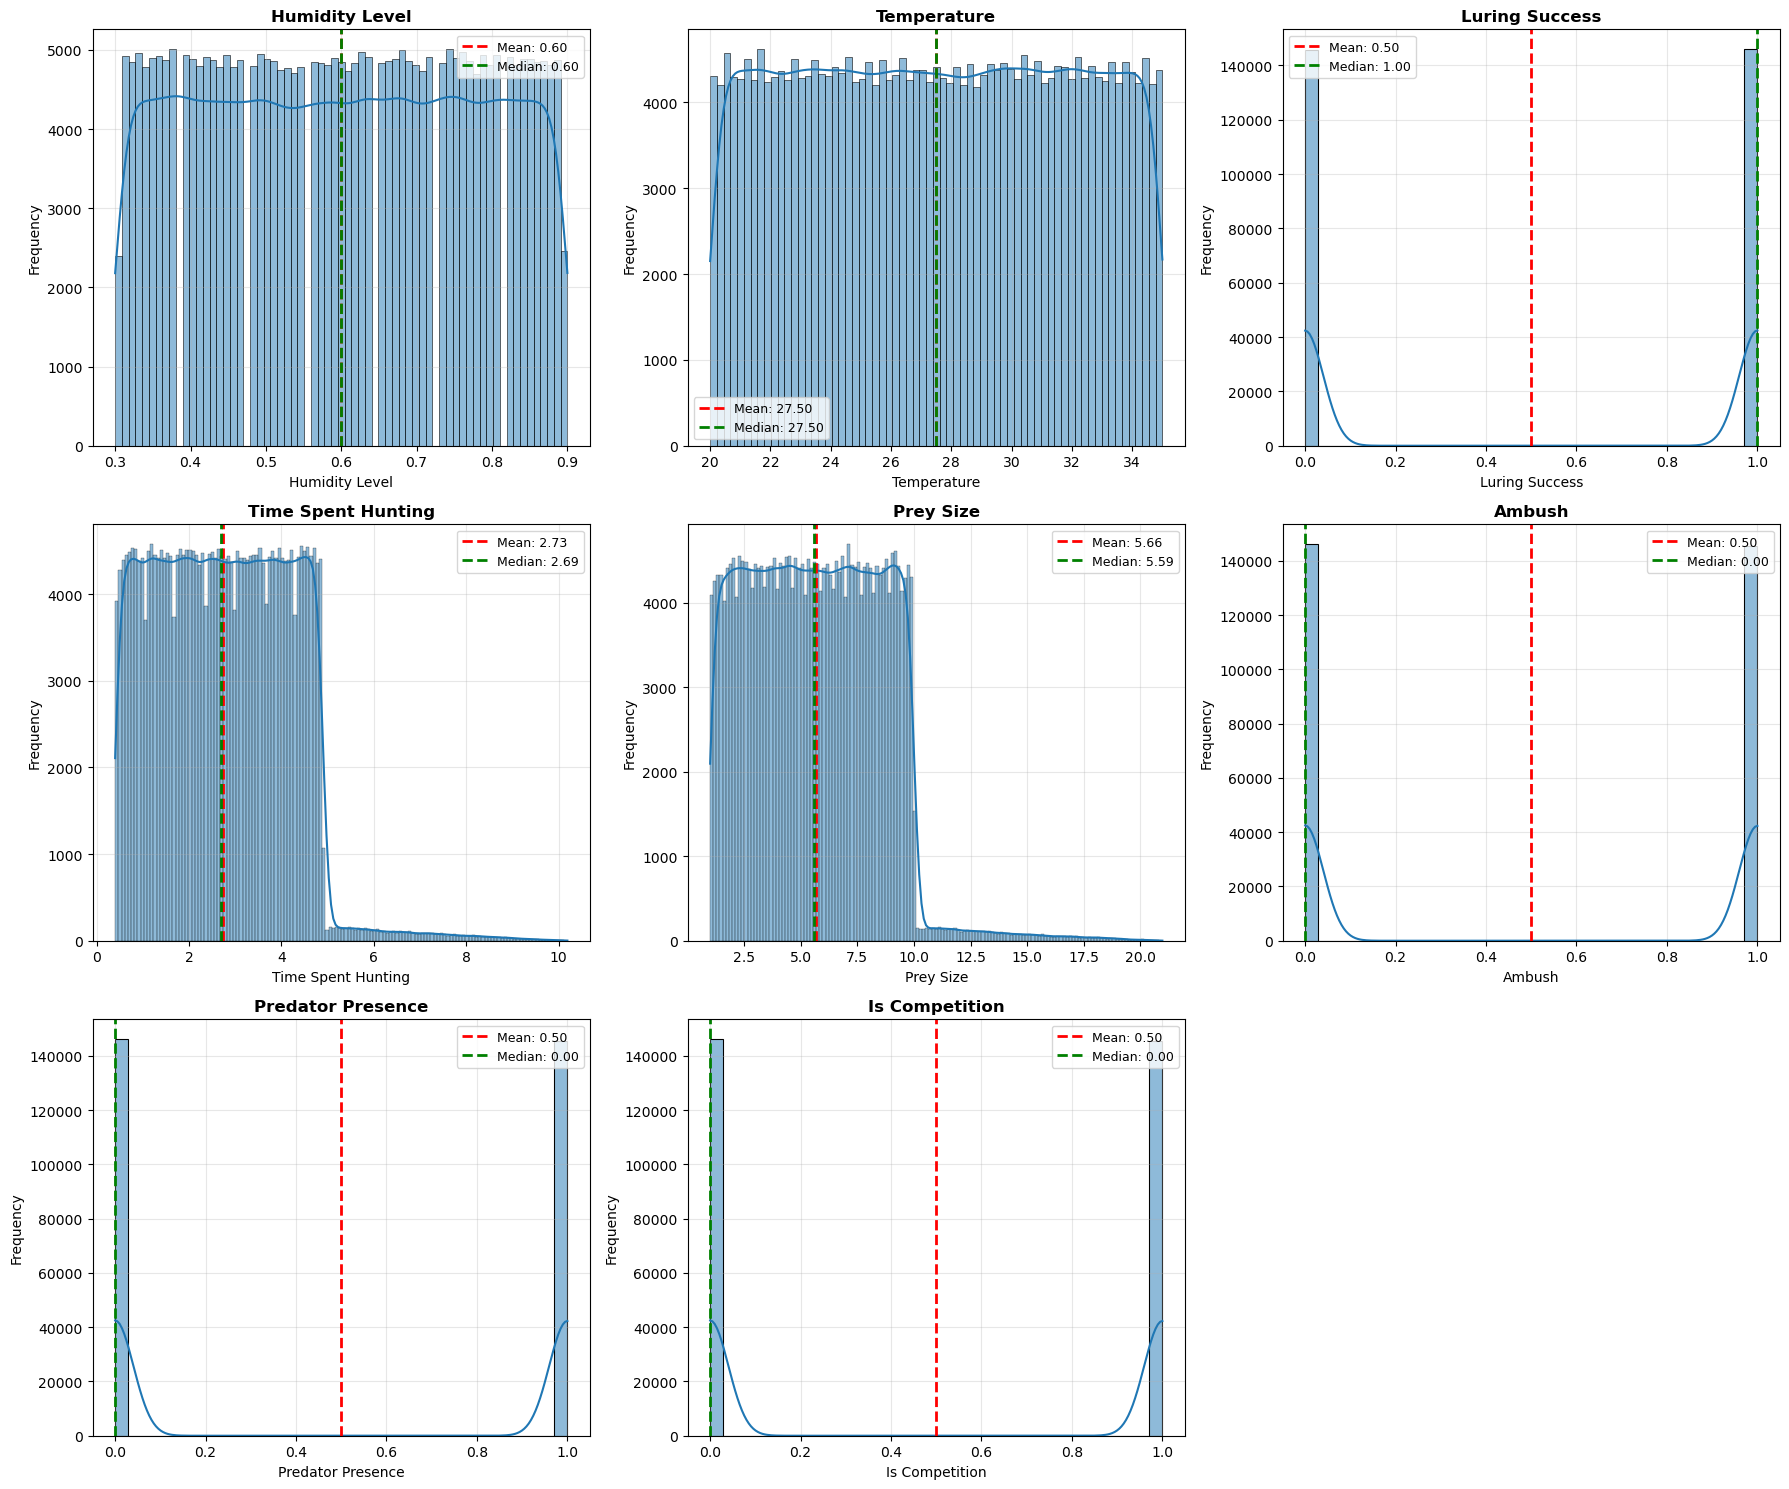

In [17]:
num_cols = dataset.select_dtypes(include=['float', 'int']).columns.tolist()
num_cols.remove('Hunting Success')

n_cols = 3
n_rows = (len(num_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten() if len(num_cols) > 1 else [axes] if n_rows == 1 else axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(dataset[col], kde=True, ax=axes[i])
    
    mean_val = dataset[col].mean()
    median_val = dataset[col].median()
    
    axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    axes[i].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
    
    axes[i].set_title(f'{col}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].set_ylabel('Frequency', fontsize=10)
    axes[i].legend(fontsize=9)
    axes[i].grid(alpha=0.3)

for i in range(len(num_cols), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Boxplots


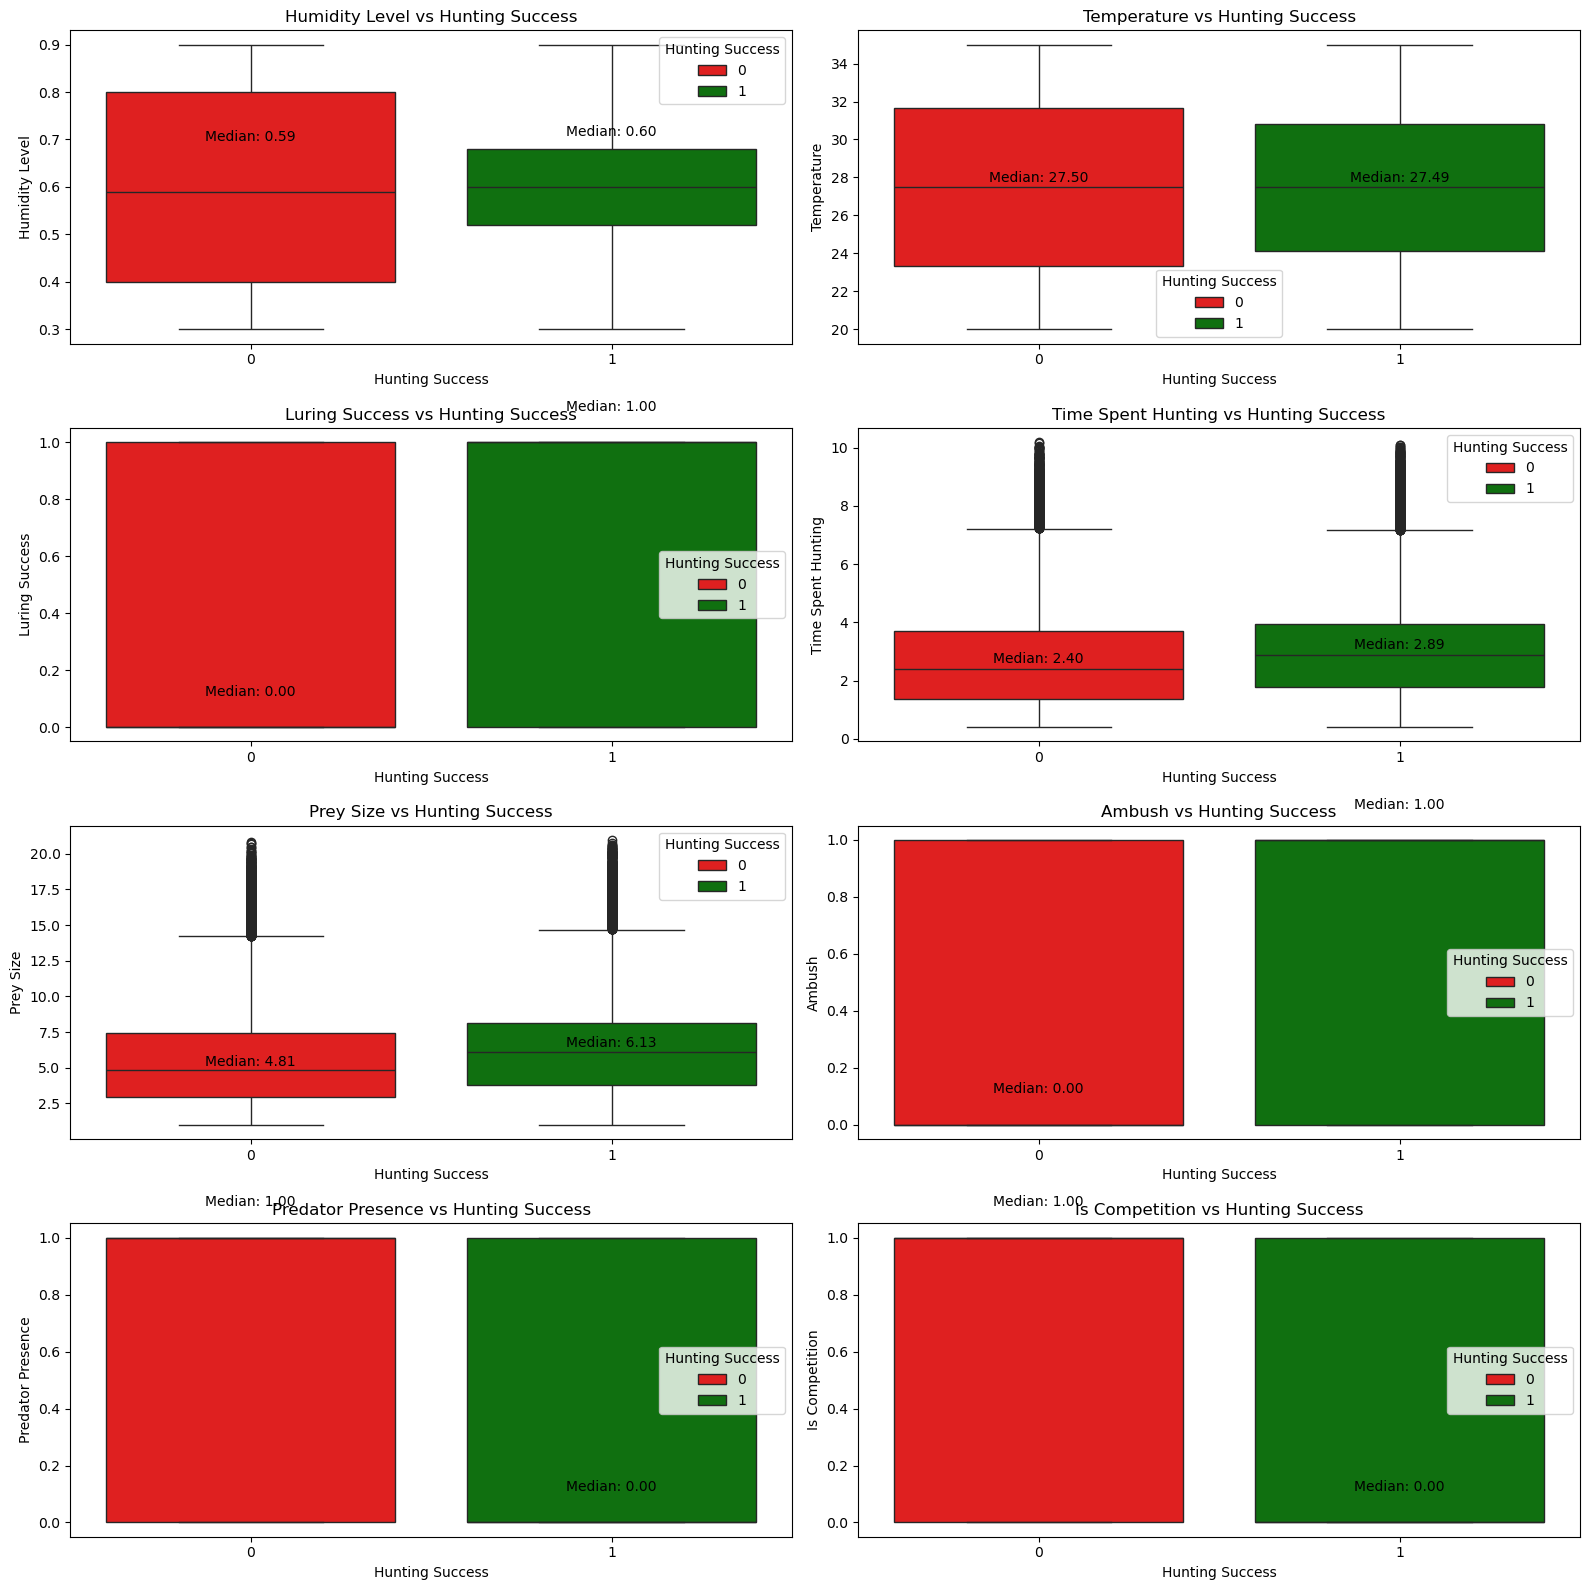

In [18]:
num_cols = dataset.select_dtypes(include=['float', 'int']).columns.tolist()

num_cols.remove('Hunting Success')
n_cols = 2  
n_rows = (len(num_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 4 * n_rows))

for i, col in enumerate(num_cols):
    row = i // n_cols
    col_idx = i % n_cols
    ax = axes[row, col_idx]
    sns.boxplot(x='Hunting Success', y=col, data=dataset, ax=ax, palette=('red', 'green'), hue='Hunting Success')
    ax.set_title(f'{col} vs Hunting Success')

    medians = dataset.groupby('Hunting Success')[col].median()
    for j, median in enumerate(medians):
        ax.text(j, median + 0.1, f'Median: {median:.2f}', ha='center', va='bottom', fontsize=10, color='black')

for i in range(len(num_cols), n_rows * n_cols):
    row = i // n_cols
    col_idx = i % n_cols
    axes[row, col_idx].axis('off')

plt.tight_layout()
plt.show()

### Analiza outlier-a
U prethodnoj analizi, primećeno je na osnovu boxplot-a da se outlier-i nalaze samo u kolonama Time Spent Hunting i Prey Size,a na osnovu histograma sa KDE vidi se da je distribucija podataka asimetrična, pa je zbog toga za detekciju broja outlier-a korišena IQR metoda. 

In [19]:
num_cols = dataset.select_dtypes(include=['float', 'int']).columns.tolist()
num_cols.remove('Hunting Success')
 
recommendations = []
 
for col in num_cols:
    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_mask = (dataset[col] < lower_bound) | (dataset[col] > upper_bound)
    outliers_data = dataset[outliers_mask]
    outlier_pct = (len(outliers_data) / len(dataset)) * 100
    
    if len(outliers_data) > 0:
        outlier_success_rate = outliers_data['Hunting Success'].mean()
        normal_success_rate = dataset[~outliers_mask]['Hunting Success'].mean()
        impact = abs(outlier_success_rate - normal_success_rate)
    else:
        impact = 0
    recommendations.append({
        'Kolona': col,
        'Broj outlier-a': len(outliers_data),
        'Procenat': f"{outlier_pct:.2f}%",
        'Uticaj na target': f"{impact*100:.2f}%",
    })
 
rec_df = pd.DataFrame(recommendations)
rec_df

,Kolona,Broj outlier-a,Procenat,Uticaj na target
0,Humidity Level,0,0.00%,0.00%
1,Temperature,0,0.00%,0.00%
2,Luring Success,0,0.00%,0.00%
3,Time Spent Hunting,1616,0.55%,3.04%
4,Prey Size,1676,0.57%,7.07%
5,Ambush,0,0.00%,0.00%
6,Predator Presence,0,0.00%,0.00%
7,Is Competition,0,0.00%,0.00%


Korelaciona matrica

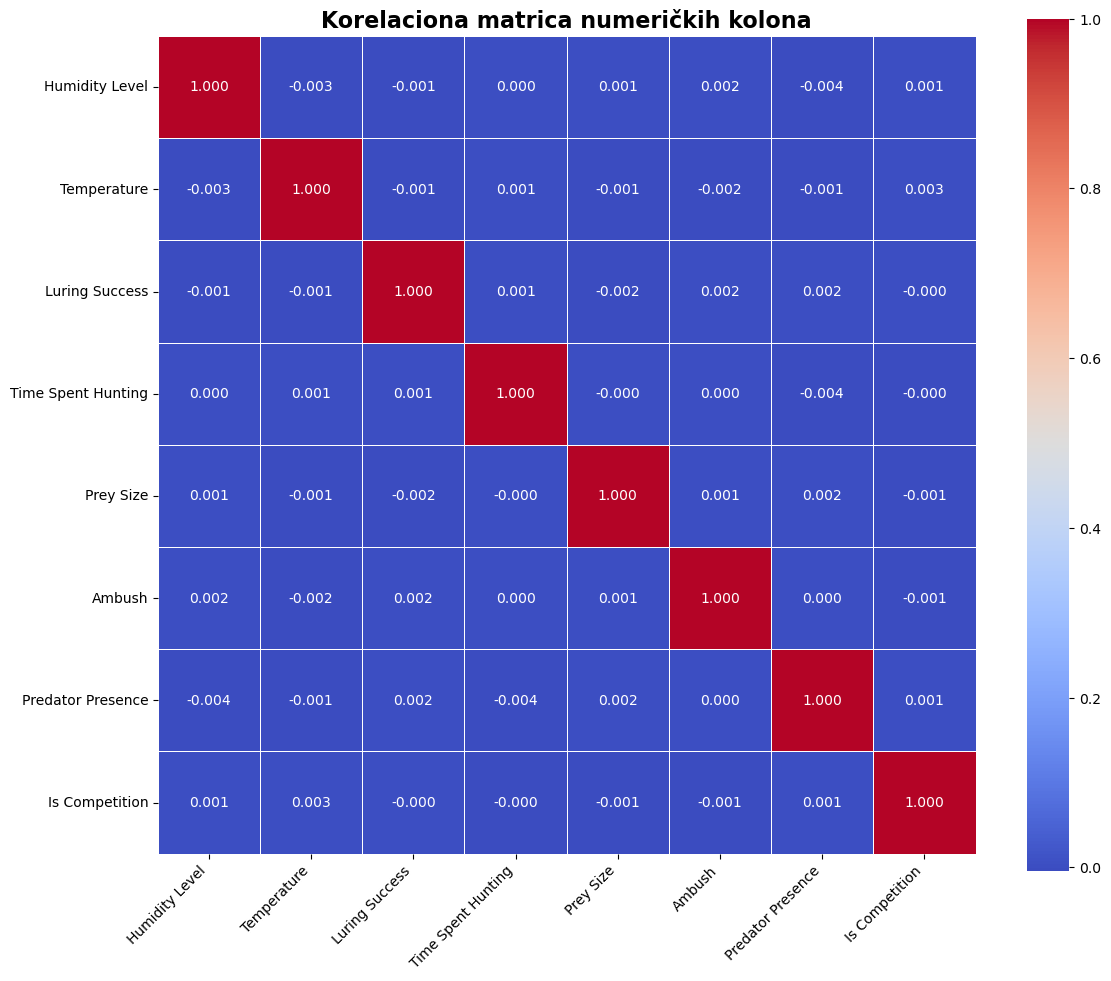

In [20]:
corr_matrix = dataset[num_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.3f', linewidths=0.5, square=True)
plt.title('Korelaciona matrica numeričkih kolona', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Korelacija feature sa target kolonom

In [21]:
from scipy.stats import pointbiserialr

for col in dataset.select_dtypes(include='number'):
    corr, p_value = pointbiserialr(dataset["Hunting Success"], dataset[col])
    print(f"{col}: {corr:.4f}")

Humidity Level: 0.0013
Temperature: -0.0002
Luring Success: 0.1110
Time Spent Hunting: 0.1098
Prey Size: 0.1366
Ambush: 0.1880
Predator Presence: -0.0709
Is Competition: -0.0707
Hunting Success: 1.0000


Analiza kategorijskih kolona

In [22]:
cat_cols = dataset.select_dtypes(include=['object']).columns.tolist()
print(f'Kategorijske kolone: {cat_cols}')


Kategorijske kolone: ['Time of Day', 'Food Availability']


Value counts za kategorijske kolone


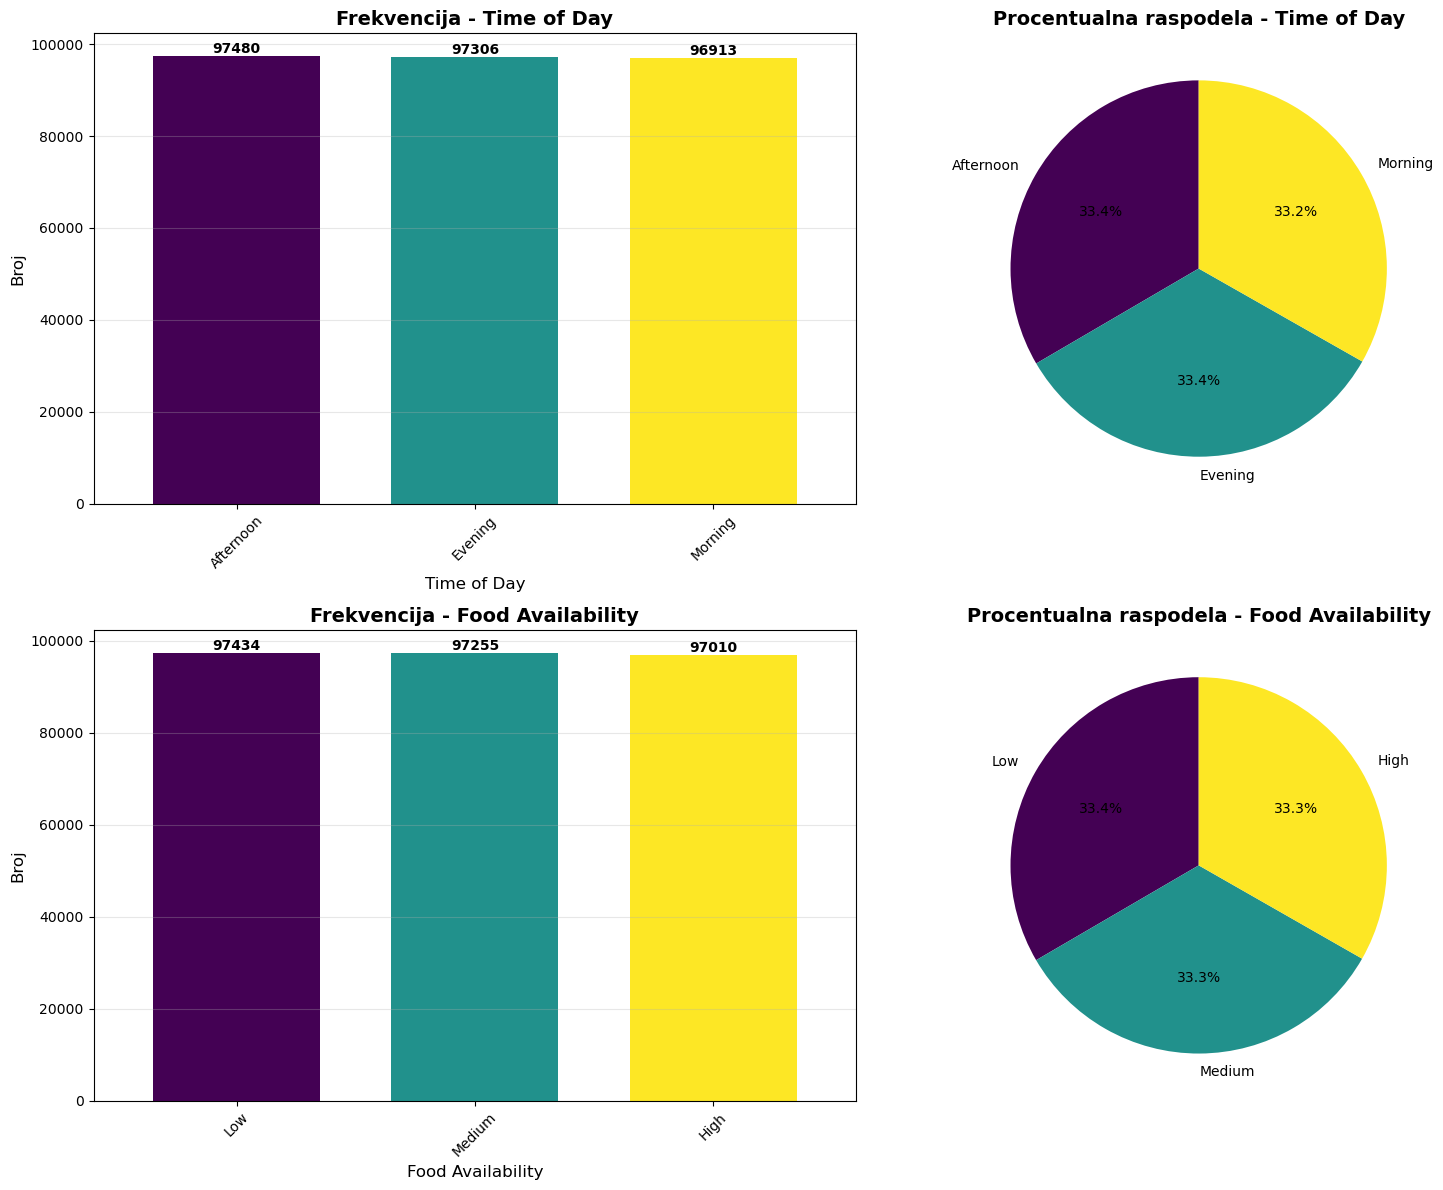

In [23]:
fig, axes = plt.subplots(nrows=len(cat_cols), ncols=2, figsize=(16, 6 * len(cat_cols)))

for i, col in enumerate(cat_cols):
    value_counts = dataset[col].value_counts()
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(value_counts)))
    value_counts.plot(kind='bar', ax=axes[i, 0], color=colors, width=0.7)
    axes[i, 0].set_title(f'Frekvencija - {col}', fontsize=14, fontweight='bold')
    axes[i, 0].set_xlabel(col, fontsize=12)
    axes[i, 0].set_ylabel('Broj', fontsize=12)
    axes[i, 0].tick_params(axis='x', rotation=45)
    axes[i, 0].grid(axis='y', alpha=0.3)
    
    for container in axes[i, 0].containers:
        axes[i, 0].bar_label(container, fmt='%d', fontweight='bold')
    
    axes[i, 1].pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%', 
                   startangle=90, colors=plt.cm.viridis(np.linspace(0, 1, len(value_counts))))
    axes[i, 1].set_title(f'Procentualna raspodela - {col}', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


Grupisanje kategorijskih kolona po target (Hunting Success)


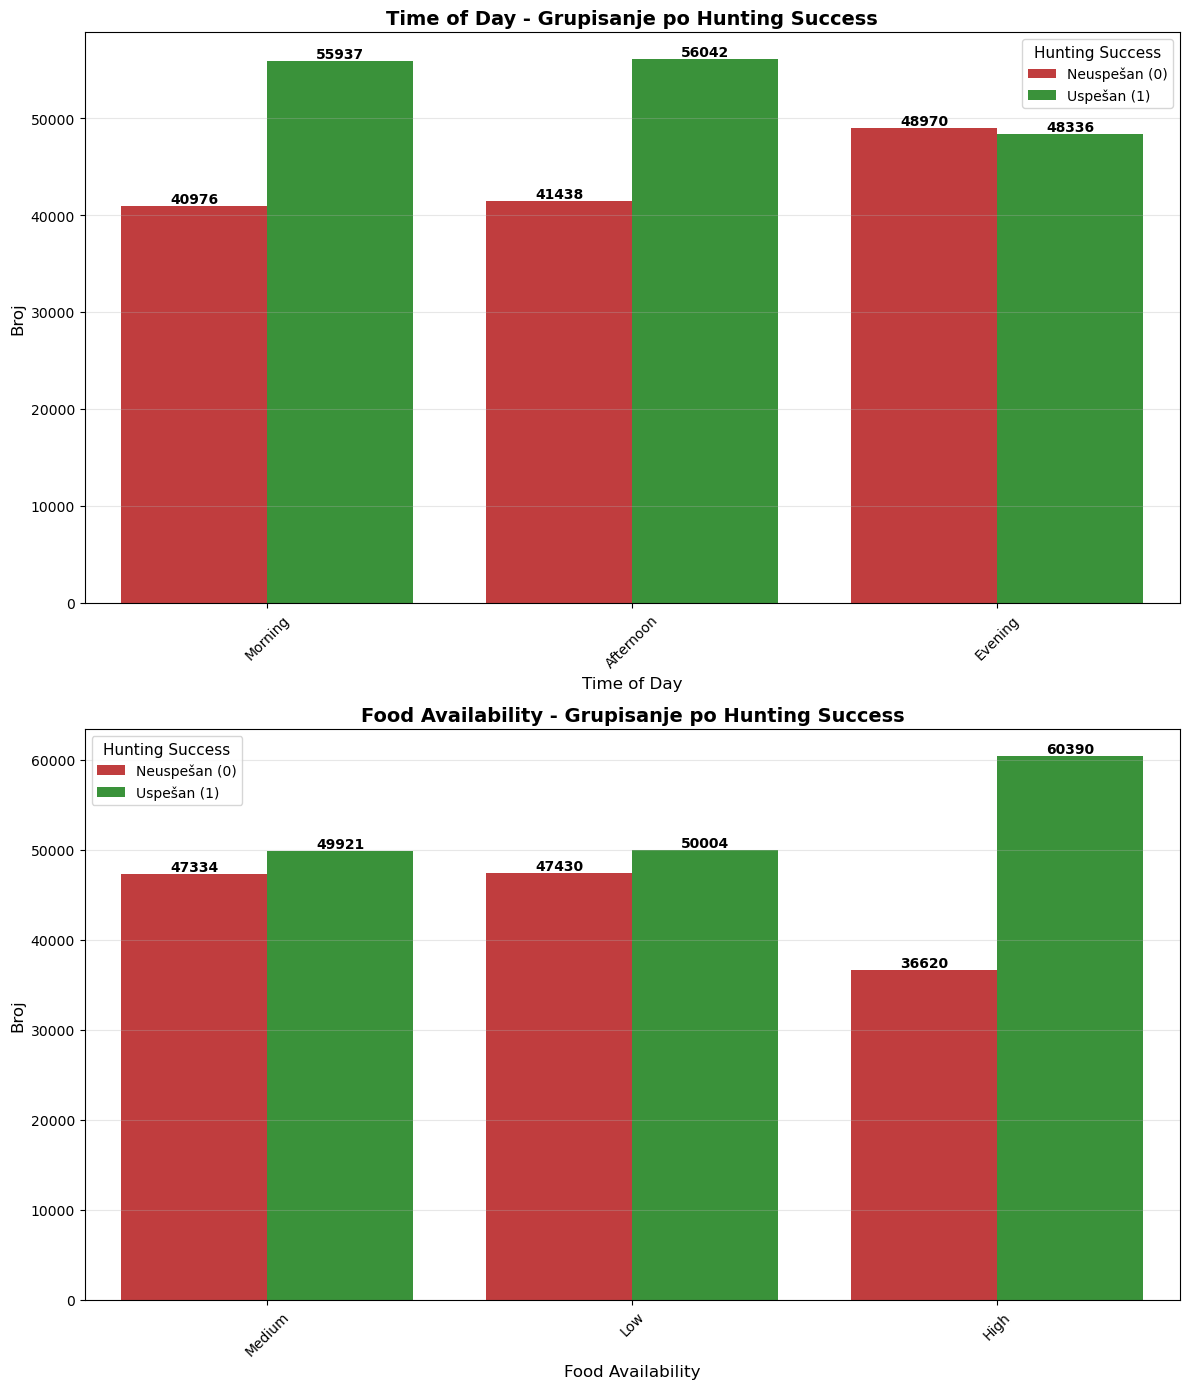

In [24]:
fig, axes = plt.subplots(nrows=len(cat_cols), ncols=1, figsize=(12, 7 * len(cat_cols)))

for i, col in enumerate(cat_cols):
    sns.countplot(data=dataset, x=col, hue='Hunting Success', ax=axes[i], palette=['#d62728', '#2ca02c'])
    axes[i].set_title(f'{col} - Grupisanje po Hunting Success', fontsize=14, fontweight='bold')
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Broj', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend(title='Hunting Success', labels=['Neuspešan (0)', 'Uspešan (1)'], title_fontsize=11, fontsize=10)
    axes[i].grid(axis='y', alpha=0.3)
    
    for container in axes[i].containers:
        axes[i].bar_label(container, fmt='%d', fontweight='bold')

plt.tight_layout()
plt.show()


Mode kategorijskih kolona

In [25]:
mode_data = []
 
for col in cat_cols:
    mode_total = dataset[col].mode()
    mode_total_value = mode_total.iloc[0] if len(mode_total) > 0 else None
    mode_total_count = (dataset[col] == mode_total_value).sum() if mode_total_value else 0

    dataset_0 = dataset[dataset['Hunting Success'] == 0]
    mode_0 = dataset_0[col].mode()
    mode_0_value = mode_0.iloc[0] if len(mode_0) > 0 else None
    mode_0_count = (dataset_0[col] == mode_0_value).sum() if mode_0_value else 0

    dataset_1 = dataset[dataset['Hunting Success'] == 1]
    mode_1 = dataset_1[col].mode()
    mode_1_value = mode_1.iloc[0] if len(mode_1) > 0 else None
    mode_1_count = (dataset_1[col] == mode_1_value).sum() if mode_1_value else 0
    mode_data.append({
        'Kategorijska kolona': col,
        'Mode (Ukupno)': mode_total_value,
        'Mode (Hunting Success = 0)': mode_0_value,
        'Mode (Hunting Success = 1)': mode_1_value,
    })
 
mode_df = pd.DataFrame(mode_data)
mode_df

,Kategorijska kolona,Mode (Ukupno),Mode (Hunting Success = 0),Mode (Hunting Success = 1)
0,Time of Day,Afternoon,Evening,Afternoon
1,Food Availability,Low,Low,High


Analiza uticaja outlier-a na target

Detaljna analiza uticaja outlier-a na target varijablu:



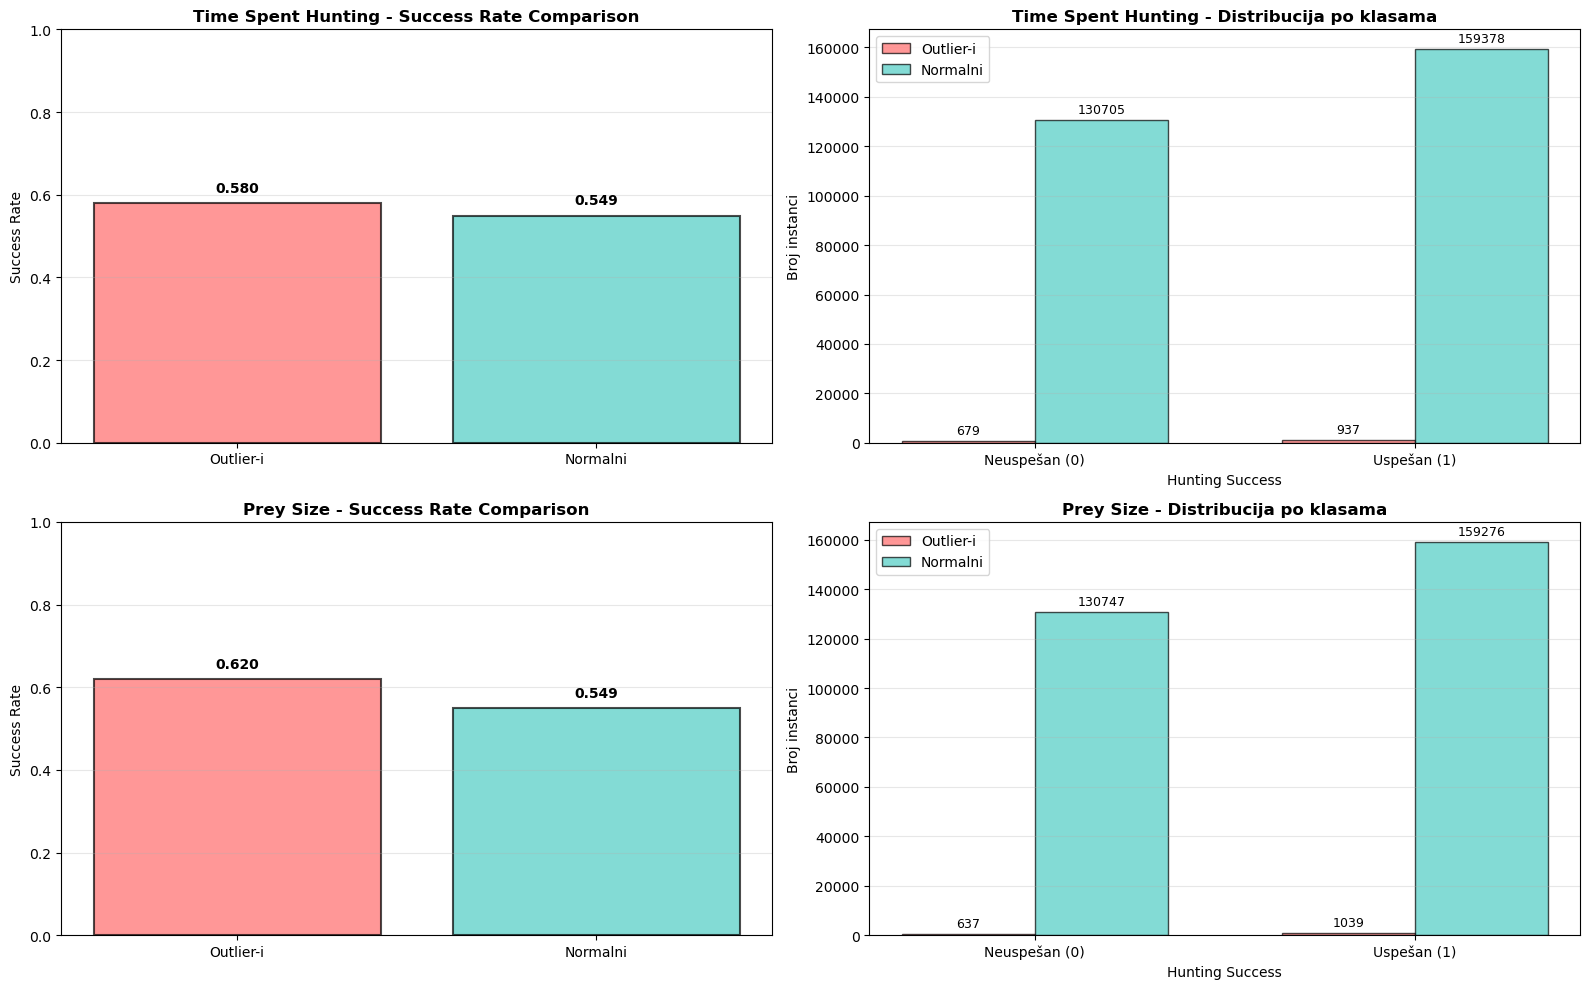

In [26]:
num_cols = dataset.select_dtypes(include=['float', 'int']).columns.tolist()
num_cols.remove('Hunting Success')

# Detaljna analiza uticaja outlier-a na target varijablu
outlier_analysis = []

for col in num_cols:
    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identifikacija outlier-a
    outliers_mask = (dataset[col] < lower_bound) | (dataset[col] > upper_bound)
    normal_mask = ~outliers_mask
    
    outliers_data = dataset[outliers_mask]
    normal_data = dataset[normal_mask]
    
    if len(outliers_data) > 0:
        # Success rate za outlier-e i normalne vrednosti
        outlier_success_rate = outliers_data['Hunting Success'].mean()
        normal_success_rate = normal_data['Hunting Success'].mean()
        
        # Distribucija po klasama za outlier-e
        outlier_dist = outliers_data['Hunting Success'].value_counts()
        outlier_dist_pct = outliers_data['Hunting Success'].value_counts(normalize=True) * 100
        
        # Distribucija po klasama za normalne vrednosti
        normal_dist = normal_data['Hunting Success'].value_counts()
        normal_dist_pct = normal_data['Hunting Success'].value_counts(normalize=True) * 100
        
        # Razlika u success rate-u
        impact = abs(outlier_success_rate - normal_success_rate)
        
        outlier_analysis.append({
            'Kolona': col,
            'Broj outlier-a': len(outliers_data),
            'Procenat outlier-a (%)': f"{(len(outliers_data) / len(dataset) * 100):.2f}%",
            'Success rate (outlier-i)': f"{outlier_success_rate:.4f}",
            'Success rate (normalni)': f"{normal_success_rate:.4f}",
            'Razlika u success rate-u': f"{impact:.4f}",
            'Outlier: Hunting Success = 0': f"{outlier_dist.get(0, 0)} ({outlier_dist_pct.get(0, 0):.2f}%)",
            'Outlier: Hunting Success = 1': f"{outlier_dist.get(1, 0)} ({outlier_dist_pct.get(1, 0):.2f}%)",
            'Normalni: Hunting Success = 0': f"{normal_dist.get(0, 0)} ({normal_dist_pct.get(0, 0):.2f}%)",
            'Normalni: Hunting Success = 1': f"{normal_dist.get(1, 0)} ({normal_dist_pct.get(1, 0):.2f}%)"
        })

outlier_analysis_df = pd.DataFrame(outlier_analysis)
print("Detaljna analiza uticaja outlier-a na target varijablu:\n")
outlier_analysis_df

# Vizualizacija uticaja outlier-a na target
outlier_cols = outlier_analysis_df['Kolona'].tolist()

if len(outlier_cols) > 0:
    fig, axes = plt.subplots(nrows=len(outlier_cols), ncols=2, figsize=(16, 5 * len(outlier_cols)))
    
    if len(outlier_cols) == 1:
        axes = axes.reshape(1, -1)
    
    for i, col in enumerate(outlier_cols):
        Q1 = dataset[col].quantile(0.25)
        Q3 = dataset[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers_mask = (dataset[col] < lower_bound) | (dataset[col] > upper_bound)
        outliers_data = dataset[outliers_mask]
        normal_data = dataset[~outliers_mask]
        
        # Graf 1: Success rate comparison
        categories = ['Outlier-i', 'Normalni']
        success_rates = [
            outliers_data['Hunting Success'].mean(),
            normal_data['Hunting Success'].mean()
        ]
        
        axes[i, 0].bar(categories, success_rates, color=['#ff6b6b', '#4ecdc4'], alpha=0.7, edgecolor='black', linewidth=1.5)
        axes[i, 0].set_title(f'{col} - Success Rate Comparison', fontsize=12, fontweight='bold')
        axes[i, 0].set_ylabel('Success Rate', fontsize=10)
        axes[i, 0].set_ylim([0, 1])
        axes[i, 0].grid(axis='y', alpha=0.3)
        
        # Dodavanje vrednosti na barove
        for j, rate in enumerate(success_rates):
            axes[i, 0].text(j, rate + 0.02, f'{rate:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        # Graf 2: Distribucija po klasama
        outlier_counts = outliers_data['Hunting Success'].value_counts().sort_index()
        normal_counts = normal_data['Hunting Success'].value_counts().sort_index()
        
        x = np.arange(2)
        width = 0.35
        
        outlier_values = [outlier_counts.get(0, 0), outlier_counts.get(1, 0)]
        normal_values = [normal_counts.get(0, 0), normal_counts.get(1, 0)]
        
        axes[i, 1].bar(x - width/2, outlier_values, width, label='Outlier-i', color='#ff6b6b', alpha=0.7, edgecolor='black')
        axes[i, 1].bar(x + width/2, normal_values, width, label='Normalni', color='#4ecdc4', alpha=0.7, edgecolor='black')
        
        axes[i, 1].set_xlabel('Hunting Success', fontsize=10)
        axes[i, 1].set_ylabel('Broj instanci', fontsize=10)
        axes[i, 1].set_title(f'{col} - Distribucija po klasama', fontsize=12, fontweight='bold')
        axes[i, 1].set_xticks(x)
        axes[i, 1].set_xticklabels(['Neuspešan (0)', 'Uspešan (1)'])
        axes[i, 1].legend()
        axes[i, 1].grid(axis='y', alpha=0.3)
        
        # Dodavanje vrednosti na barove
        for j, (out_val, norm_val) in enumerate(zip(outlier_values, normal_values)):
            if out_val > 0:
                axes[i, 1].text(j - width/2, out_val + max(outlier_values + normal_values) * 0.01, 
                               str(out_val), ha='center', va='bottom', fontsize=9)
            if norm_val > 0:
                axes[i, 1].text(j + width/2, norm_val + max(outlier_values + normal_values) * 0.01, 
                               str(norm_val), ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
else:
    print("Nema outlier-a u numeričkim kolonama.")


Zapazanje: Outlier-i imaju veći success rate -> veći plen i duže vreme provedeno u lovu = veća uspešnost u lovu
Pretpostavka:  Ekstremne vrednosti su povezane sa većim uspehom, nisu greške u podacima i predstavjaju retke ali važne slučajeve
Odluka: Ne uklanjati outlier-e.
Mogući dalji koraci:
1) Odraditi transformaciju (log/sqrt) ako modeli osetljivi na ekstremne vrednosti imaju problema
2) Dodati feature engineering - npr. binarna kolona Large Prey ili Long Hunt koja eksplicitno označava ekstremne vrednosti

Kolone Time of Day and Food Availability su kategorijske i na njih može da se primeni one-hot encoding

In [27]:
time_of_day_one_hot = pd.get_dummies(dataset['Time of Day'], prefix='Time of Day', dummy_na=False)
food_availability_one_hot = pd.get_dummies(dataset['Food Availability'], prefix='Food Availability', dummy_na=False)

dataset = dataset.drop(columns=['Time of Day', 'Food Availability'])

dataset = pd.concat([dataset, time_of_day_one_hot, food_availability_one_hot], axis=1)

ostale_kolone = [col for col in dataset.columns if col not in list(time_of_day_one_hot.columns) + list(food_availability_one_hot.columns)]
hunting_success_index = ostale_kolone.index('Hunting Success')

nove_kolone = ostale_kolone[:hunting_success_index] + list(time_of_day_one_hot.columns) + list(food_availability_one_hot.columns) + ['Hunting Success'] + ostale_kolone[hunting_success_index + 1:]

dataset = dataset[nove_kolone]

dataset = dataset.replace({True: 1, False: 0})

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 291699 entries, 0 to 299999
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Humidity Level            291699 non-null  float64
 1   Temperature               291699 non-null  float64
 2   Luring Success            291699 non-null  int64  
 3   Time Spent Hunting        291699 non-null  float64
 4   Prey Size                 291699 non-null  float64
 5   Ambush                    291699 non-null  int64  
 6   Predator Presence         291699 non-null  int64  
 7   Is Competition            291699 non-null  int64  
 8   Time of Day_Afternoon     291699 non-null  int64  
 9   Time of Day_Evening       291699 non-null  int64  
 10  Time of Day_Morning       291699 non-null  int64  
 11  Food Availability_High    291699 non-null  int64  
 12  Food Availability_Low     291699 non-null  int64  
 13  Food Availability_Medium  291699 non-null  int64 

Podela dataseta na test i train setove

In [28]:
y = dataset['Hunting Success']
X = dataset.drop(columns=['Hunting Success'])

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

(291699, 14)
(291699,)
X_train shape: (233359, 14)
X_test shape: (58340, 14)


Kreiranje Baseline modela i izbor modela za poredjenje:


In [29]:
from lazypredict.Supervised import CLASSIFIERS
 
skip = [
    "SVC",
    "NuSVC"
]
 
fast_classifiers = [cls for name, cls in CLASSIFIERS if name not in skip]
print(fast_classifiers)
 
clf = LazyClassifier( verbose=0, ignore_warnings=True, classifiers=fast_classifiers )
 
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
 
print(models)

[<class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>, <class 'sklearn.ensemble._bagging.BaggingClassifier'>, <class 'sklearn.naive_bayes.BernoulliNB'>, <class 'sklearn.calibration.CalibratedClassifierCV'>, <class 'sklearn.naive_bayes.CategoricalNB'>, <class 'sklearn.tree._classes.DecisionTreeClassifier'>, <class 'sklearn.dummy.DummyClassifier'>, <class 'sklearn.tree._classes.ExtraTreeClassifier'>, <class 'sklearn.ensemble._forest.ExtraTreesClassifier'>, <class 'sklearn.model_selection._classification_threshold.FixedThresholdClassifier'>, <class 'sklearn.naive_bayes.GaussianNB'>, <class 'sklearn.neighbors._classification.KNeighborsClassifier'>, <class 'sklearn.semi_supervised._label_propagation.LabelPropagation'>, <class 'sklearn.semi_supervised._label_propagation.LabelSpreading'>, <class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'>, <class 'sklearn.svm._classes.LinearSVC'>, <class 'sklearn.linear_model._logistic.LogisticRegression'>, <class 'sklearn.neighbors.

  0%|          | 0/30 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 128252, number of negative: 105107
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 233359, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549591 -> initscore=0.199018
[LightGBM] [Info] Start training from score 0.199018
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
RandomForestClassifier             0.97               0.97     0.97      0.97   
LGBMClassifier                     0.97               0.97     0.97      0.97   
XGBClassifier                      0.97               0.97     0.97      0.97   
BaggingClassifier                  0.

Izabrani su modeli sa >0.9 preciznošću: Random Forest Classifier, LGM Classifier, XGB Classifier, Bagging Classifier, Extra Trees Classifier i Decision Tree Classifier

<b>Random Forest Classifier - Baseline Model</b>

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
 
rf_baseline = RandomForestClassifier()
 
rf_baseline.fit(X_train, y_train)
 
y_pred_rf = rf_baseline.predict(X_test)
 
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average="weighted")
report_rf = classification_report(y_test, y_pred_rf)
cm_rf = confusion_matrix(y_test, y_pred_rf)
 
print("Random Forest Classifier - Baseline Model Performance")
print(f'Accuracy: {accuracy_rf:.4f}')
print(f'F1 Score: {f1_rf:.4f}')
print("\nClassification Report:\n", report_rf)
print("Confusion Matrix:\n", cm_rf)

Random Forest Classifier - Baseline Model Performance
Accuracy: 0.9718
F1 Score: 0.9718

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97     26277
           1       0.96      0.99      0.97     32063

    accuracy                           0.97     58340
   macro avg       0.97      0.97      0.97     58340
weighted avg       0.97      0.97      0.97     58340

Confusion Matrix:
 [[24961  1316]
 [  327 31736]]


<b>LGM Classifier - Baseline Model</b>

In [31]:
from lightgbm import LGBMClassifier

lgbm_baseline = LGBMClassifier(random_state=42)

lgbm_baseline.fit(X_train, y_train)

y_pred_lgbm = lgbm_baseline.predict(X_test)

accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
f1_lgbm = f1_score(y_test, y_pred_lgbm, average="weighted")
report_lgbm = classification_report(y_test, y_pred_lgbm)
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)

print("LightGBM Classifier - Baseline Model Performance")
print(f'Accuracy: {accuracy_lgbm:.4f}')
print(f'F1 Score: {f1_lgbm:.4f}')
print("\nClassification Report:\n", report_lgbm)
print("Confusion Matrix:\n", cm_lgbm)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 128252, number of negative: 105107
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 847
[LightGBM] [Info] Number of data points in the train set: 233359, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549591 -> initscore=0.199018
[LightGBM] [Info] Start training from score 0.199018
LightGBM Classifier - Baseline Model Performance
Accuracy: 0.9715
F1 Score: 0.9715

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97     26277
           1       0.96      0.99      0.97     32063

    accuracy                           0.97     58340
   macro avg       0.97      0.97   

<b>XGB Classifier - Baseline model</b>

In [32]:
from xgboost import XGBClassifier

xgb_baseline = XGBClassifier(
    random_state=42,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    objective='binary:logistic'
)

xgb_baseline.fit(X_train, y_train)

y_pred_xgb = xgb_baseline.predict(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb, average="weighted")
report_xgb = classification_report(y_test, y_pred_xgb)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

print("XGB Classifier - Baseline Model Performance")
print(f'Accuracy: {accuracy_xgb:.4f}')
print(f'F1 Score: {f1_xgb:.4f}')
print("\nClassification Report:\n", report_xgb)
print("Confusion Matrix:\n", cm_xgb)

XGB Classifier - Baseline Model Performance
Accuracy: 0.9713
F1 Score: 0.9712

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97     26277
           1       0.96      0.99      0.97     32063

    accuracy                           0.97     58340
   macro avg       0.97      0.97      0.97     58340
weighted avg       0.97      0.97      0.97     58340

Confusion Matrix:
 [[24933  1344]
 [  332 31731]]


<b> Bagging Classifier - Baseline model</b>

In [33]:
from sklearn.ensemble import BaggingClassifier

bagging_clf = BaggingClassifier(random_state=42)
bagging_clf.fit(X_train, y_train)

y_pred_bagging = bagging_clf.predict(X_test)

accuracy_bagging = accuracy_score(y_test, y_pred_bagging)
f1_bagging = f1_score(y_test, y_pred_bagging)
report_bagging = classification_report(y_test, y_pred_bagging)
cm_bagging = confusion_matrix(y_test, y_pred_bagging)

print("Bagging Classifier - Baseline Model Performance")
print(f'Accuracy: {accuracy_bagging:.4f}')
print(f'F1 Score: {f1_bagging:.4f}')
print("\nClassification Report:\n", report_bagging)
print("Confusion Matrix:\n", cm_bagging)

Bagging Classifier - Baseline Model Performance
Accuracy: 0.9694
F1 Score: 0.9725

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.97     26277
           1       0.96      0.99      0.97     32063

    accuracy                           0.97     58340
   macro avg       0.97      0.97      0.97     58340
weighted avg       0.97      0.97      0.97     58340

Confusion Matrix:
 [[24963  1314]
 [  472 31591]]


<b>Extra Trees Classifier - Baseline model</b>

In [34]:
from sklearn.ensemble import ExtraTreesClassifier

etc_baseline = ExtraTreesClassifier(random_state=42)
etc_baseline.fit(X_train, y_train)

y_pred_etc = etc_baseline.predict(X_test)

accuracy_etc = accuracy_score(y_test, y_pred_etc)
f1_etc = f1_score(y_test, y_pred_etc)
report_etc = classification_report(y_test, y_pred_etc)
cm_etc = confusion_matrix(y_test, y_pred_etc)

print("Extra Trees Classifier - Baseline Model Performance")
print(f'Accuracy: {accuracy_etc:.4f}')
print(f'F1 Score: {f1_etc:.4f}')
print("\nClassification Report:\n", report_etc)
print("Confusion Matrix:\n", cm_etc)

Extra Trees Classifier - Baseline Model Performance
Accuracy: 0.9537
F1 Score: 0.9587

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.92      0.95     26277
           1       0.94      0.98      0.96     32063

    accuracy                           0.95     58340
   macro avg       0.96      0.95      0.95     58340
weighted avg       0.95      0.95      0.95     58340

Confusion Matrix:
 [[24297  1980]
 [  723 31340]]


<b>Decision Tree Classifier - Baseline model</b>

In [35]:
from sklearn.tree import DecisionTreeClassifier

dtc_baseline = DecisionTreeClassifier(random_state=42)
dtc_baseline.fit(X_train, y_train)

y_pred_dtc = dtc_baseline.predict(X_test)

accuracy_dtc = accuracy_score(y_test, y_pred_dtc)
f1_dtc = f1_score(y_test, y_pred_dtc)
report_dtc = classification_report(y_test, y_pred_dtc)
cm_dtc = confusion_matrix(y_test, y_pred_dtc)

print("Decision Tree Classifier - Baseline Model Performance")
print(f'Accuracy: {accuracy_dtc:.4f}')
print(f'F1 Score: {f1_dtc:.4f}')
print("\nClassification Report:\n", report_dtc)
print("Confusion Matrix:\n", cm_dtc)

Decision Tree Classifier - Baseline Model Performance
Accuracy: 0.9425
F1 Score: 0.9475

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.94     26277
           1       0.95      0.94      0.95     32063

    accuracy                           0.94     58340
   macro avg       0.94      0.94      0.94     58340
weighted avg       0.94      0.94      0.94     58340

Confusion Matrix:
 [[24712  1565]
 [ 1792 30271]]


## Optimizovanje hiperparametara izabranih algoritama mašinskog učenja

## Random Forest Classifier 

Počinje optimizacija hiperparametara...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Optimizacija završena za 1131.69 sekundi

NAJBOLJI HIPERPARAMETRI:
n_estimators: 300
min_samples_split: 5
min_samples_leaf: 1
max_features: log2
max_depth: 10
class_weight: None

Najbolji CV F1 Score: 0.9758

Feature IMPORTANCE:


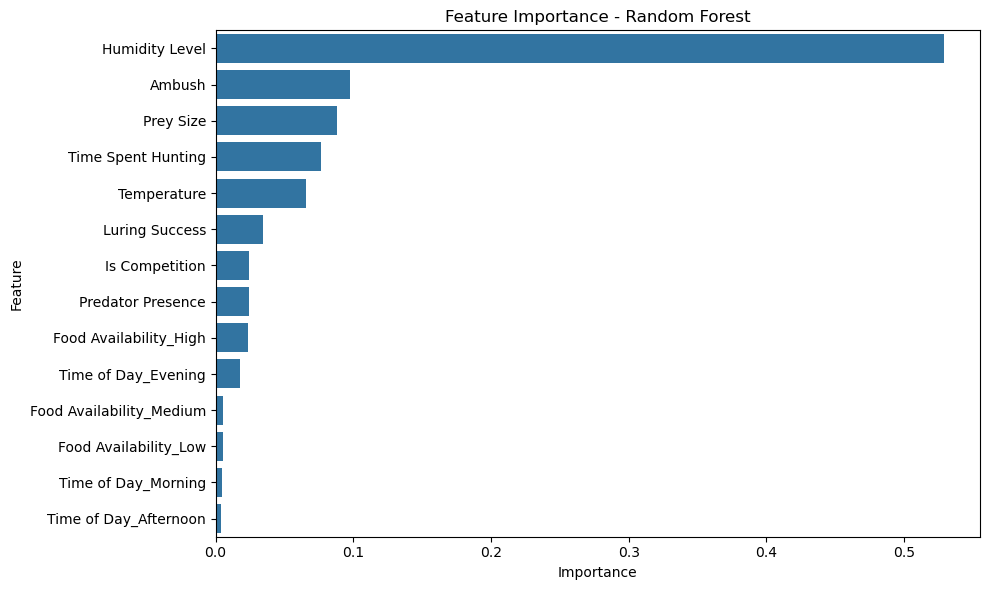


ZAVRŠNA PROCENA NA TEST SKUPU:
Accuracy: 97.21%
F1 Score: 97.50%

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97     26277
           1       0.96      0.99      0.98     32063

    accuracy                           0.97     58340
   macro avg       0.97      0.97      0.97     58340
weighted avg       0.97      0.97      0.97     58340



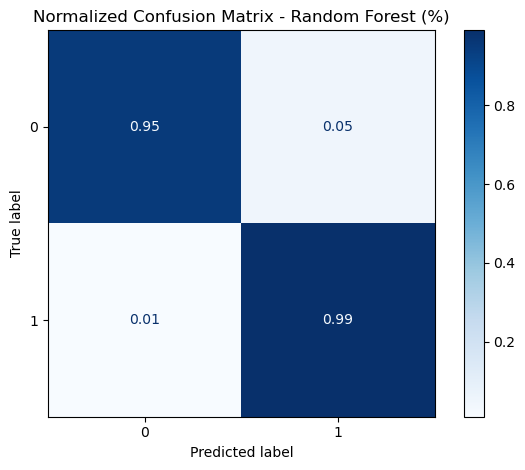

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import time

param_distributions = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': [None, 'balanced']
}

cv = StratifiedKFold(
    n_splits=5, 
    shuffle=True, 
    random_state=42
)

rf_base = RandomForestClassifier(
    random_state=42, 
    n_jobs=-1
)

print("Počinje optimizacija hiperparametara...")
start_time = time.time()

rf_random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_distributions,
    n_iter=20,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rf_random_search.fit(X_train, y_train)

end_time = time.time()
print(f"\nOptimizacija završena za {end_time - start_time:.2f} sekundi")



print("\n" + "=" * 70)
print("NAJBOLJI HIPERPARAMETRI:")
print("=" * 70)

best_params = rf_random_search.best_params_
for param, value in best_params.items():
    print(f"{param}: {value}")

print(f"\nNajbolji CV F1 Score: {rf_random_search.best_score_:.4f}")

best_rf = rf_random_search.best_estimator_

# importances = best_rf.feature_importances_
# std = np.std([tree.feature_importances_ for tree in best_rf.estimators_], axis=0)

# feature_importance = pd.DataFrame({
#     'Feature': X_train.columns,
#     'Importance': importances,
#     'Std': std
# }).sort_values('Importance', ascending=False)

# print("\nFeature IMPORTANCE:")

# plt.figure(figsize=(10, 6))
# sns.barplot(
#     data=feature_importance,
#     x='Importance',
#     y='Feature',
# )

# plt.title('Feature Importance - Random Forest')
# plt.xlabel('Importance')
# plt.ylabel('Feature')
# plt.tight_layout()
# plt.show()


#Evaluacija
y_rf_pred_test = best_rf.predict(X_test)
y_rf_pred_test_proba = best_rf.predict_proba(X_test)[:, 1]

accuracy_test = accuracy_score(y_test, y_rf_pred_test)
f1_test = f1_score(y_test, y_rf_pred_test)

print("\n" + "="*60)
print("ZAVRŠNA PROCENA NA TEST SKUPU:")
print("="*60)
print(f'Accuracy: {accuracy_test * 100:.2f}%')
print(f'F1 Score: {f1_test * 100:.2f}%')
print ("\nClassification Report:\n", classification_report(y_test, y_rf_pred_test))

cm_norm = confusion_matrix(y_test, y_rf_pred_test, normalize='true') * 100 # u procentima

disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm)
disp.plot(cmap='Blues', values_format='.2f')
plt.title('Normalized Confusion Matrix - Random Forest (%)')
plt.tight_layout()
plt.show()

## LGBM Classifier 


Počinje optimizacija hiperparametara za LGBM...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 128252, number of negative: 105107
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 847
[LightGBM] [Info] Number of data points in the train set: 233359, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549591 -> initscore=0.199018
[LightGBM] [Info] Start training from score 0.199018

Optimizacija završena za 183.07 sekundi

NAJBOLJI HIPERPARAMETRI (LGBM):
subsample: 1.0
reg_lambda: 0.5
reg_alpha: 0.0
num_leaves: 31
n_estimators: 200
min_child_samples: 30
max_depth: -1
learning_rate: 0.05
colsample_bytree: 0.9

Najbolji CV F1 Score

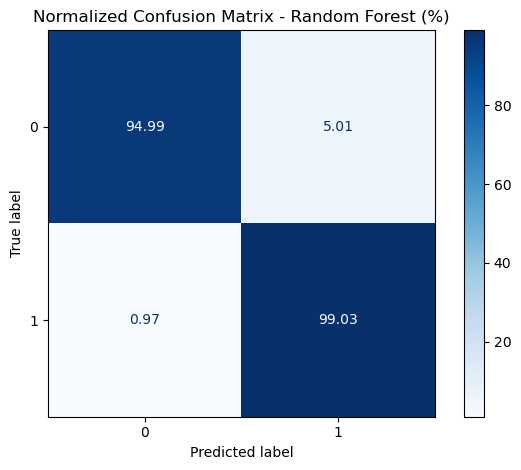

In [38]:
from lightgbm import LGBMClassifier

lgbm_param_dist = {
    'num_leaves': [31, 63, 127],
    'max_depth': [10, 20, -1],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 400],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_samples': [10, 20, 30],
    'reg_alpha': [0.0, 0.1],
    'reg_lambda': [0.0, 0.5, 1.0]
}

lgbm_base = LGBMClassifier(
    random_state=42,
    objective='binary',
    n_jobs=-1
)

print("Počinje optimizacija hiperparametara za LGBM...")
lgbm_start = time.time()

lgbm_random_search = RandomizedSearchCV(
    estimator=lgbm_base,
    param_distributions=lgbm_param_dist,
    n_iter=20,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

lgbm_random_search.fit(X_train, y_train)

lgbm_end = time.time()
print(f"\nOptimizacija završena za {lgbm_end - lgbm_start:.2f} sekundi")

print("\n" + "=" * 60)
print("NAJBOLJI HIPERPARAMETRI (LGBM):")
print("=" * 60)
best_lgbm_params = lgbm_random_search.best_params_
for param, value in best_lgbm_params.items():
    print(f"{param}: {value}")

print(f"\nNajbolji CV F1 Score: {lgbm_random_search.best_score_:.4f}")

best_lgbm = lgbm_random_search.best_estimator_

# print("\n" + "="*60)
# print("DODATNE INFORMACIJE O CROSS-VALIDATION (LGBM):")
# print("="*60)
# print("Broj foldova: 5")
# print("Scoring metrika: F1 Score")
# print("Broj testiranih kombinacija: 40")

# print("\n" + "="*60)
# print("TOP 10 NAJVAŽNIJIH FEATURE-A (LGBM):")
# print("="*60)
# lgbm_feature_importance = pd.DataFrame({
#     'Feature': X_train.columns,
#     'Importance': best_lgbm.feature_importances_
# }).sort_values('Importance', ascending=False)

# print(lgbm_feature_importance.head(10).to_string(index=False))

# plt.figure(figsize=(10, 8))
# lgbm_top_features = lgbm_feature_importance.head(10)
# sns.barplot(data=lgbm_top_features, y='Feature', x='Importance', palette='viridis')
# plt.title('Top 10 Najvažnijih Feature-a - LGBM', fontsize=14, fontweight='bold')
# plt.xlabel('Importance', fontsize=12)
# plt.ylabel('Feature', fontsize=12)
# plt.tight_layout()
# plt.show()

#evaluacija
y_rf_pred_test = best_rf.predict(X_test)

accuracy_test = accuracy_score(y_test, y_rf_pred_test)
f1_test = f1_score(y_test, y_rf_pred_test)

print("\n" + "=" * 60)
print("ZAVRŠNA PROCENA NA TEST SKUPU - LGBM:")
print("=" * 60)
print(f'Accuracy: {accuracy_test * 100:.2f}%')
print(f'F1 Score: {f1_test * 100:.2f}%')
print ("\nClassification Report:\n", classification_report(y_test, y_rf_pred_test))

cm_norm = confusion_matrix(y_test, y_rf_pred_test, normalize='true') * 100 # u procentima

disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm)
disp.plot(cmap='Blues', values_format='.2f')
plt.title('Normalized Confusion Matrix - Random Forest (%)')
plt.tight_layout()
plt.show()
# lgbm_y_pred_test = best_lgbm.predict(X_test)
# lgbm_accuracy_test = accuracy_score(y_test, lgbm_y_pred_test)
# lgbm_f1_test = f1_score(y_test, lgbm_y_pred_test, average="weighted")
# lgbm_report_test = classification_report(y_test, lgbm_y_pred_test)
# lgbm_cm_test = confusion_matrix(y_test, lgbm_y_pred_test)




# print(f'Accuracy: {lgbm_accuracy_test:.4f}')
# print(f'F1 Score: {lgbm_f1_test:.4f}')
# print("\nClassification Report:\n", lgbm_report_test)
# print("Confusion Matrix:\n", lgbm_cm_test)



## XGB Classifier

Počinje optimizacija hiperparametara za XGB...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Optimizacija završena za 91.01 sekundi

NAJBOLJI HIPERPARAMETRI (XGB):
subsample: 0.7
reg_lambda: 1
reg_alpha: 0
n_estimators: 500
min_child_weight: 3
max_depth: 3
learning_rate: 0.05
gamma: 0.5
colsample_bytree: 1.0

Najbolji CV F1 Score: 0.9752

ZAVRŠNA PROCENA NA TEST SKUPU:
Accuracy: 97.21%
F1 Score: 97.50%

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97     26277
           1       0.96      0.99      0.98     32063

    accuracy                           0.97     58340
   macro avg       0.97      0.97      0.97     58340
weighted avg       0.97      0.97      0.97     58340



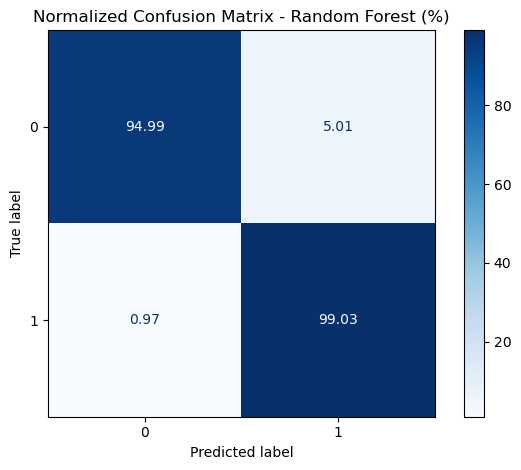

In [39]:
from xgboost import XGBClassifier

xgb_base = XGBClassifier(
    random_state=42,
    objective='binary:logistic',
    n_estimators=300,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    eval_metric='logloss'
)

xgb_param_dist = {
    'n_estimators': [200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5, 1.0],
    'min_child_weight': [1, 3, 5, 10],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

print("Počinje optimizacija hiperparametara za XGB...")
xgb_start = time.time()

xgb_random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=xgb_param_dist,
    n_iter=20,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

xgb_random_search.fit(X_train, y_train)

xgb_end = time.time()
print(f"\nOptimizacija završena za {xgb_end - xgb_start:.2f} sekundi")

print("\n" + "="*60)
print("NAJBOLJI HIPERPARAMETRI (XGB):")
print("="*60)
best_xgb_params = xgb_random_search.best_params_
for param, value in best_xgb_params.items():
    print(f"{param}: {value}")

print(f"\nNajbolji CV F1 Score: {xgb_random_search.best_score_:.4f}")

best_xgb = xgb_random_search.best_estimator_

# print("\n" + "="*60)
# print("DODATNE INFORMACIJE O CROSS-VALIDATION (XGB):")
# print("="*60)
# print("Broj foldova: 5")
# print("Scoring metrika: F1 Score")
# print("Broj testiranih kombinacija: 40")

# print("\n" + "="*60)
# print("TOP 10 NAJVAŽNIJIH FEATURE-A (XGB):")
# print("="*60)
# xgb_feature_importance = pd.DataFrame({
#     'Feature': X_train.columns,
#     'Importance': best_xgb.feature_importances_
# }).sort_values('Importance', ascending=False)

# print(xgb_feature_importance.head(10).to_string(index=False))

# plt.figure(figsize=(10, 8))
# xgb_top_features = xgb_feature_importance.head(10)
# sns.barplot(data=xgb_top_features, y='Feature', x='Importance', palette='viridis')
# plt.title('Top 10 Najvažnijih Feature-a - XGB', fontsize=14, fontweight='bold')
# plt.xlabel('Importance', fontsize=12)
# plt.ylabel('Feature', fontsize=12)
# plt.tight_layout()
# plt.show()

#evaluacija

xgb_y_pred_test = best_xgb.predict(X_test)


xgb_accuracy_test = accuracy_score(y_test, xgb_y_pred_test)
xgb_f1_test = f1_score(y_test, xgb_y_pred_test, average="weighted")

print("\n" + "="*60)
print("ZAVRŠNA PROCENA NA TEST SKUPU:")
print("="*60)
print(f'Accuracy: {accuracy_test * 100:.2f}%')
print(f'F1 Score: {f1_test * 100:.2f}%')
print ("\nClassification Report:\n", classification_report(y_test, y_rf_pred_test))

cm_norm = confusion_matrix(y_test, y_rf_pred_test, normalize='true') * 100 # u procentima

disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm)
disp.plot(cmap='Blues', values_format='.2f')
plt.title('Normalized Confusion Matrix - Random Forest (%)')
plt.tight_layout()
plt.show()

## Bagging Classifier

Počinje optimizacija hiperparametara za XGB...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Optimizacija završena za 99.97 sekundi

NAJBOLJI HIPERPARAMETRI (XGB):
subsample: 0.7
reg_lambda: 1
reg_alpha: 0
n_estimators: 500
min_child_weight: 3
max_depth: 3
learning_rate: 0.05
gamma: 0.5
colsample_bytree: 1.0

Najbolji CV F1 Score: 0.9752

NAJBOLJI HIPERPARAMETRI (Bagging):
subsample: 0.7
reg_lambda: 1
reg_alpha: 0
n_estimators: 500
min_child_weight: 3
max_depth: 3
learning_rate: 0.05
gamma: 0.5
colsample_bytree: 1.0

Najbolji CV F1 Score: 0.9752

ZAVRŠNA PROCENA NA TEST SKUPU (Bagging):
Accuracy: 97.13%
F1 Score: 97.12%

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97     26277
           1       0.96      0.99      0.97     32063

    accuracy                           0.97     58340
   macro avg       0.97      0.97      0.97     58340
weighted avg       0.97      0.97      0.97     58340



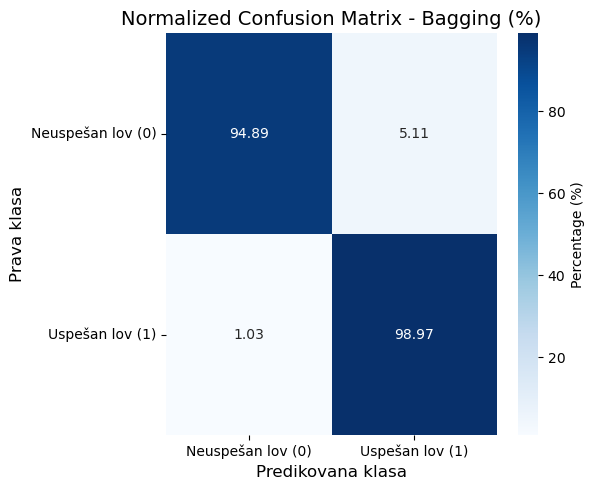

In [40]:
from xgboost import XGBClassifier

bagging_base = BaggingClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

bagging_param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}

print("Počinje optimizacija hiperparametara za XGB...")
xgb_start = time.time()

bagging_random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=xgb_param_dist,
    n_iter=20,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

bagging_random_search.fit(X_train, y_train)

xgb_end = time.time()
print(f"\nOptimizacija završena za {xgb_end - xgb_start:.2f} sekundi")

print("\n" + "="*60)
print("NAJBOLJI HIPERPARAMETRI (XGB):")
print("="*60)
best_xgb_params = xgb_random_search.best_params_
for param, value in best_xgb_params.items():
    print(f"{param}: {value}")

print(f"\nNajbolji CV F1 Score: {xgb_random_search.best_score_:.4f}")

best_xgb = xgb_random_search.best_estimator_

print("\n" + "="*60)
print("NAJBOLJI HIPERPARAMETRI (Bagging):")
print("="*60)
best_bagging_params = bagging_random_search.best_params_
for param, value in best_bagging_params.items():
    print(f"{param}: {value}")

print(f"\nNajbolji CV F1 Score: {bagging_random_search.best_score_:.4f}")

best_bagging = bagging_random_search.best_estimator_

bagging_y_pred_test = best_bagging.predict(X_test)

bagging_accuracy_test = accuracy_score(y_test, bagging_y_pred_test)
bagging_f1_test = f1_score(y_test, bagging_y_pred_test, average="weighted")

print("\n" + "="*60)
print("ZAVRŠNA PROCENA NA TEST SKUPU (Bagging):")
print("="*60)
print(f'Accuracy: {bagging_accuracy_test * 100:.2f}%')
print(f'F1 Score: {bagging_f1_test * 100:.2f}%')
print("\nClassification Report:\n", classification_report(y_test, bagging_y_pred_test))

cm_norm = confusion_matrix(y_test, bagging_y_pred_test, normalize='true') * 100

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    xticklabels=['Neuspešan lov (0)', 'Uspešan lov (1)'],
    yticklabels=['Neuspešan lov (0)', 'Uspešan lov (1)'],
    cbar_kws={'label': 'Percentage (%)'}
)
plt.ylabel('Prava klasa', fontsize=12)
plt.xlabel('Predikovana klasa', fontsize=12)
plt.title('Normalized Confusion Matrix - Bagging (%)', fontsize=14)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Extra Trees Classifier

In [ ]:
etc_base = ExtraTreesClassifier(
    random_state=42,
    n_estimators=100,  # standardna start vrednost
    n_jobs=-1
)

etc_param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced']
}

print("Počinje optimizacija hiperparametara za Extra Trees...")
start_time = time.time()

etc_random_search = RandomizedSearchCV(
    estimator=etc_base,
    param_distributions=etc_param_dist,
    n_iter=20,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

etc_random_search.fit(X_train, y_train)
end_time = time.time()
print(f"\nOptimizacija završena za {end_time - start_time:.2f} sekundi")

print("\n" + "="*60)
print("NAJBOLJI HIPERPARAMETRI (Extra Trees):")
print("="*60)
best_etc_params = etc_random_search.best_params_
for param, value in best_etc_params.items():
    print(f"{param}: {value}")

print(f"\nNajbolji CV F1 Score: {etc_random_search.best_score_:.4f}")

best_etc = etc_random_search.best_estimator_

etc_y_pred_test = best_etc.predict(X_test)

etc_accuracy_test = accuracy_score(y_test, etc_y_pred_test)
etc_f1_test = f1_score(y_test, etc_y_pred_test, average="weighted")

print("\n" + "="*60)
print("ZAVRŠNA PROCENA NA TEST SKUPU (Extra Trees):")
print("="*60)
print(f'Accuracy: {etc_accuracy_test * 100:.2f}%')
print(f'F1 Score: {etc_f1_test * 100:.2f}%')
print("\nClassification Report:\n", classification_report(y_test, etc_y_pred_test))

cm_norm = confusion_matrix(y_test, etc_y_pred_test, normalize='true') * 100

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    xticklabels=['Neuspešan lov (0)', 'Uspešan lov (1)'],
    yticklabels=['Neuspešan lov (0)', 'Uspešan lov (1)'],
    cbar_kws={'label': 'Percentage (%)'}
)
plt.ylabel('Prava klasa', fontsize=12)
plt.xlabel('Predikovana klasa', fontsize=12)
plt.title('Normalized Confusion Matrix - Extra Trees (%)', fontsize=14)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Počinje optimizacija hiperparametara za Extra Trees...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


## Decision Trees Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

dt_base = DecisionTreeClassifier(
    random_state=42
)

dt_param_dist = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced']
}

print("Počinje optimizacija hiperparametara za Decision Tree...")
start_time = time.time()

dt_random_search = RandomizedSearchCV(
    estimator=dt_base,
    param_distributions=dt_param_dist,
    n_iter=20,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

dt_random_search.fit(X_train, y_train)
end_time = time.time()
print(f"\nOptimizacija završena za {end_time - start_time:.2f} sekundi")

print("\n" + "="*60)
print("NAJBOLJI HIPERPARAMETRI (Decision Tree):")
print("="*60)
best_dt_params = dt_random_search.best_params_
for param, value in best_dt_params.items():
    print(f"{param}: {value}")

print(f"\nNajbolji CV F1 Score: {dt_random_search.best_score_:.4f}")

best_dt = dt_random_search.best_estimator_

dt_y_pred_test = best_dt.predict(X_test)

dt_accuracy_test = accuracy_score(y_test, dt_y_pred_test)
dt_f1_test = f1_score(y_test, dt_y_pred_test, average="weighted")

print("\n" + "="*60)
print("ZAVRŠNA PROCENA NA TEST SKUPU (Decision Tree):")
print("="*60)
print(f'Accuracy: {dt_accuracy_test * 100:.2f}%')
print(f'F1 Score: {dt_f1_test * 100:.2f}%')
print("\nClassification Report:\n", classification_report(y_test, dt_y_pred_test))

cm_norm = confusion_matrix(y_test, dt_y_pred_test, normalize='true') * 100

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    xticklabels=['Neuspešan lov (0)', 'Uspešan lov (1)'],
    yticklabels=['Neuspešan lov (0)', 'Uspešan lov (1)'],
    cbar_kws={'label': 'Percentage (%)'}
)
plt.ylabel('Prava klasa', fontsize=12)
plt.xlabel('Predikovana klasa', fontsize=12)
plt.title('Normalized Confusion Matrix - Decision Tree (%)', fontsize=14)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()